# STA-6543 Assignment 3

Jason Gillette

## Question 13
 
Uses the Weekly data set, part of the ISLP package.

In [4]:
from ISLP import load_data

# Load the weekly dataset
weekly = load_data('Weekly')

# View the first few rows
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


## Question 13a.

Produce some numerical and graphical summaries of the weekly data. Do there appear to be any patterns?

In [5]:
# numerical summary
print(weekly.describe())

# data types and non-null counts
print(weekly.info())

              Year         Lag1         Lag2         Lag3         Lag4  \
count  1089.000000  1089.000000  1089.000000  1089.000000  1089.000000   
mean   2000.048669     0.150585     0.151079     0.147205     0.145818   
std       6.033182     2.357013     2.357254     2.360502     2.360279   
min    1990.000000   -18.195000   -18.195000   -18.195000   -18.195000   
25%    1995.000000    -1.154000    -1.154000    -1.158000    -1.158000   
50%    2000.000000     0.241000     0.241000     0.241000     0.238000   
75%    2005.000000     1.405000     1.409000     1.409000     1.409000   
max    2010.000000    12.026000    12.026000    12.026000    12.026000   

              Lag5       Volume        Today  
count  1089.000000  1089.000000  1089.000000  
mean      0.139893     1.574618     0.149899  
std       2.361285     1.686636     2.356927  
min     -18.195000     0.087465   -18.195000  
25%      -1.166000     0.332022    -1.154000  
50%       0.234000     1.002680     0.241000  
75% 

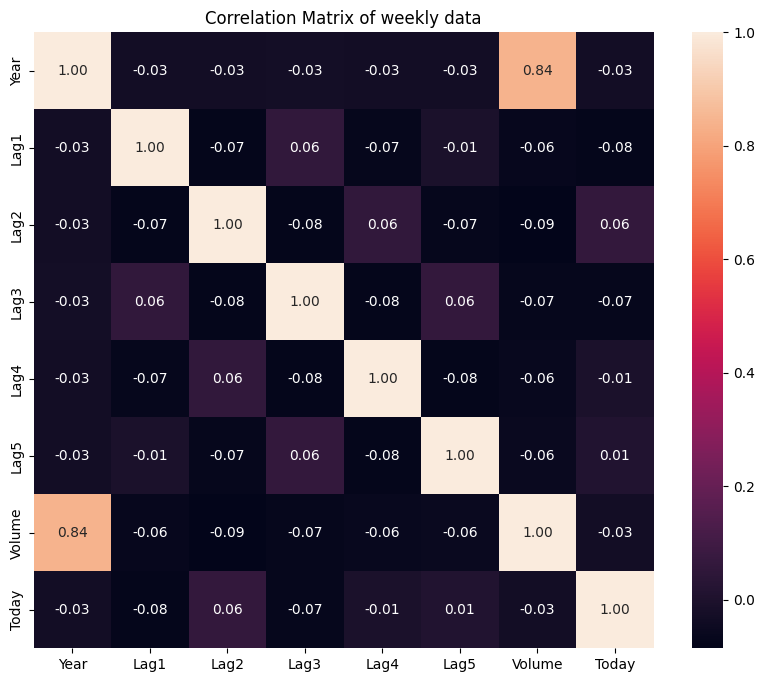

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(weekly.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title("Correlation Matrix of weekly data")
plt.show()

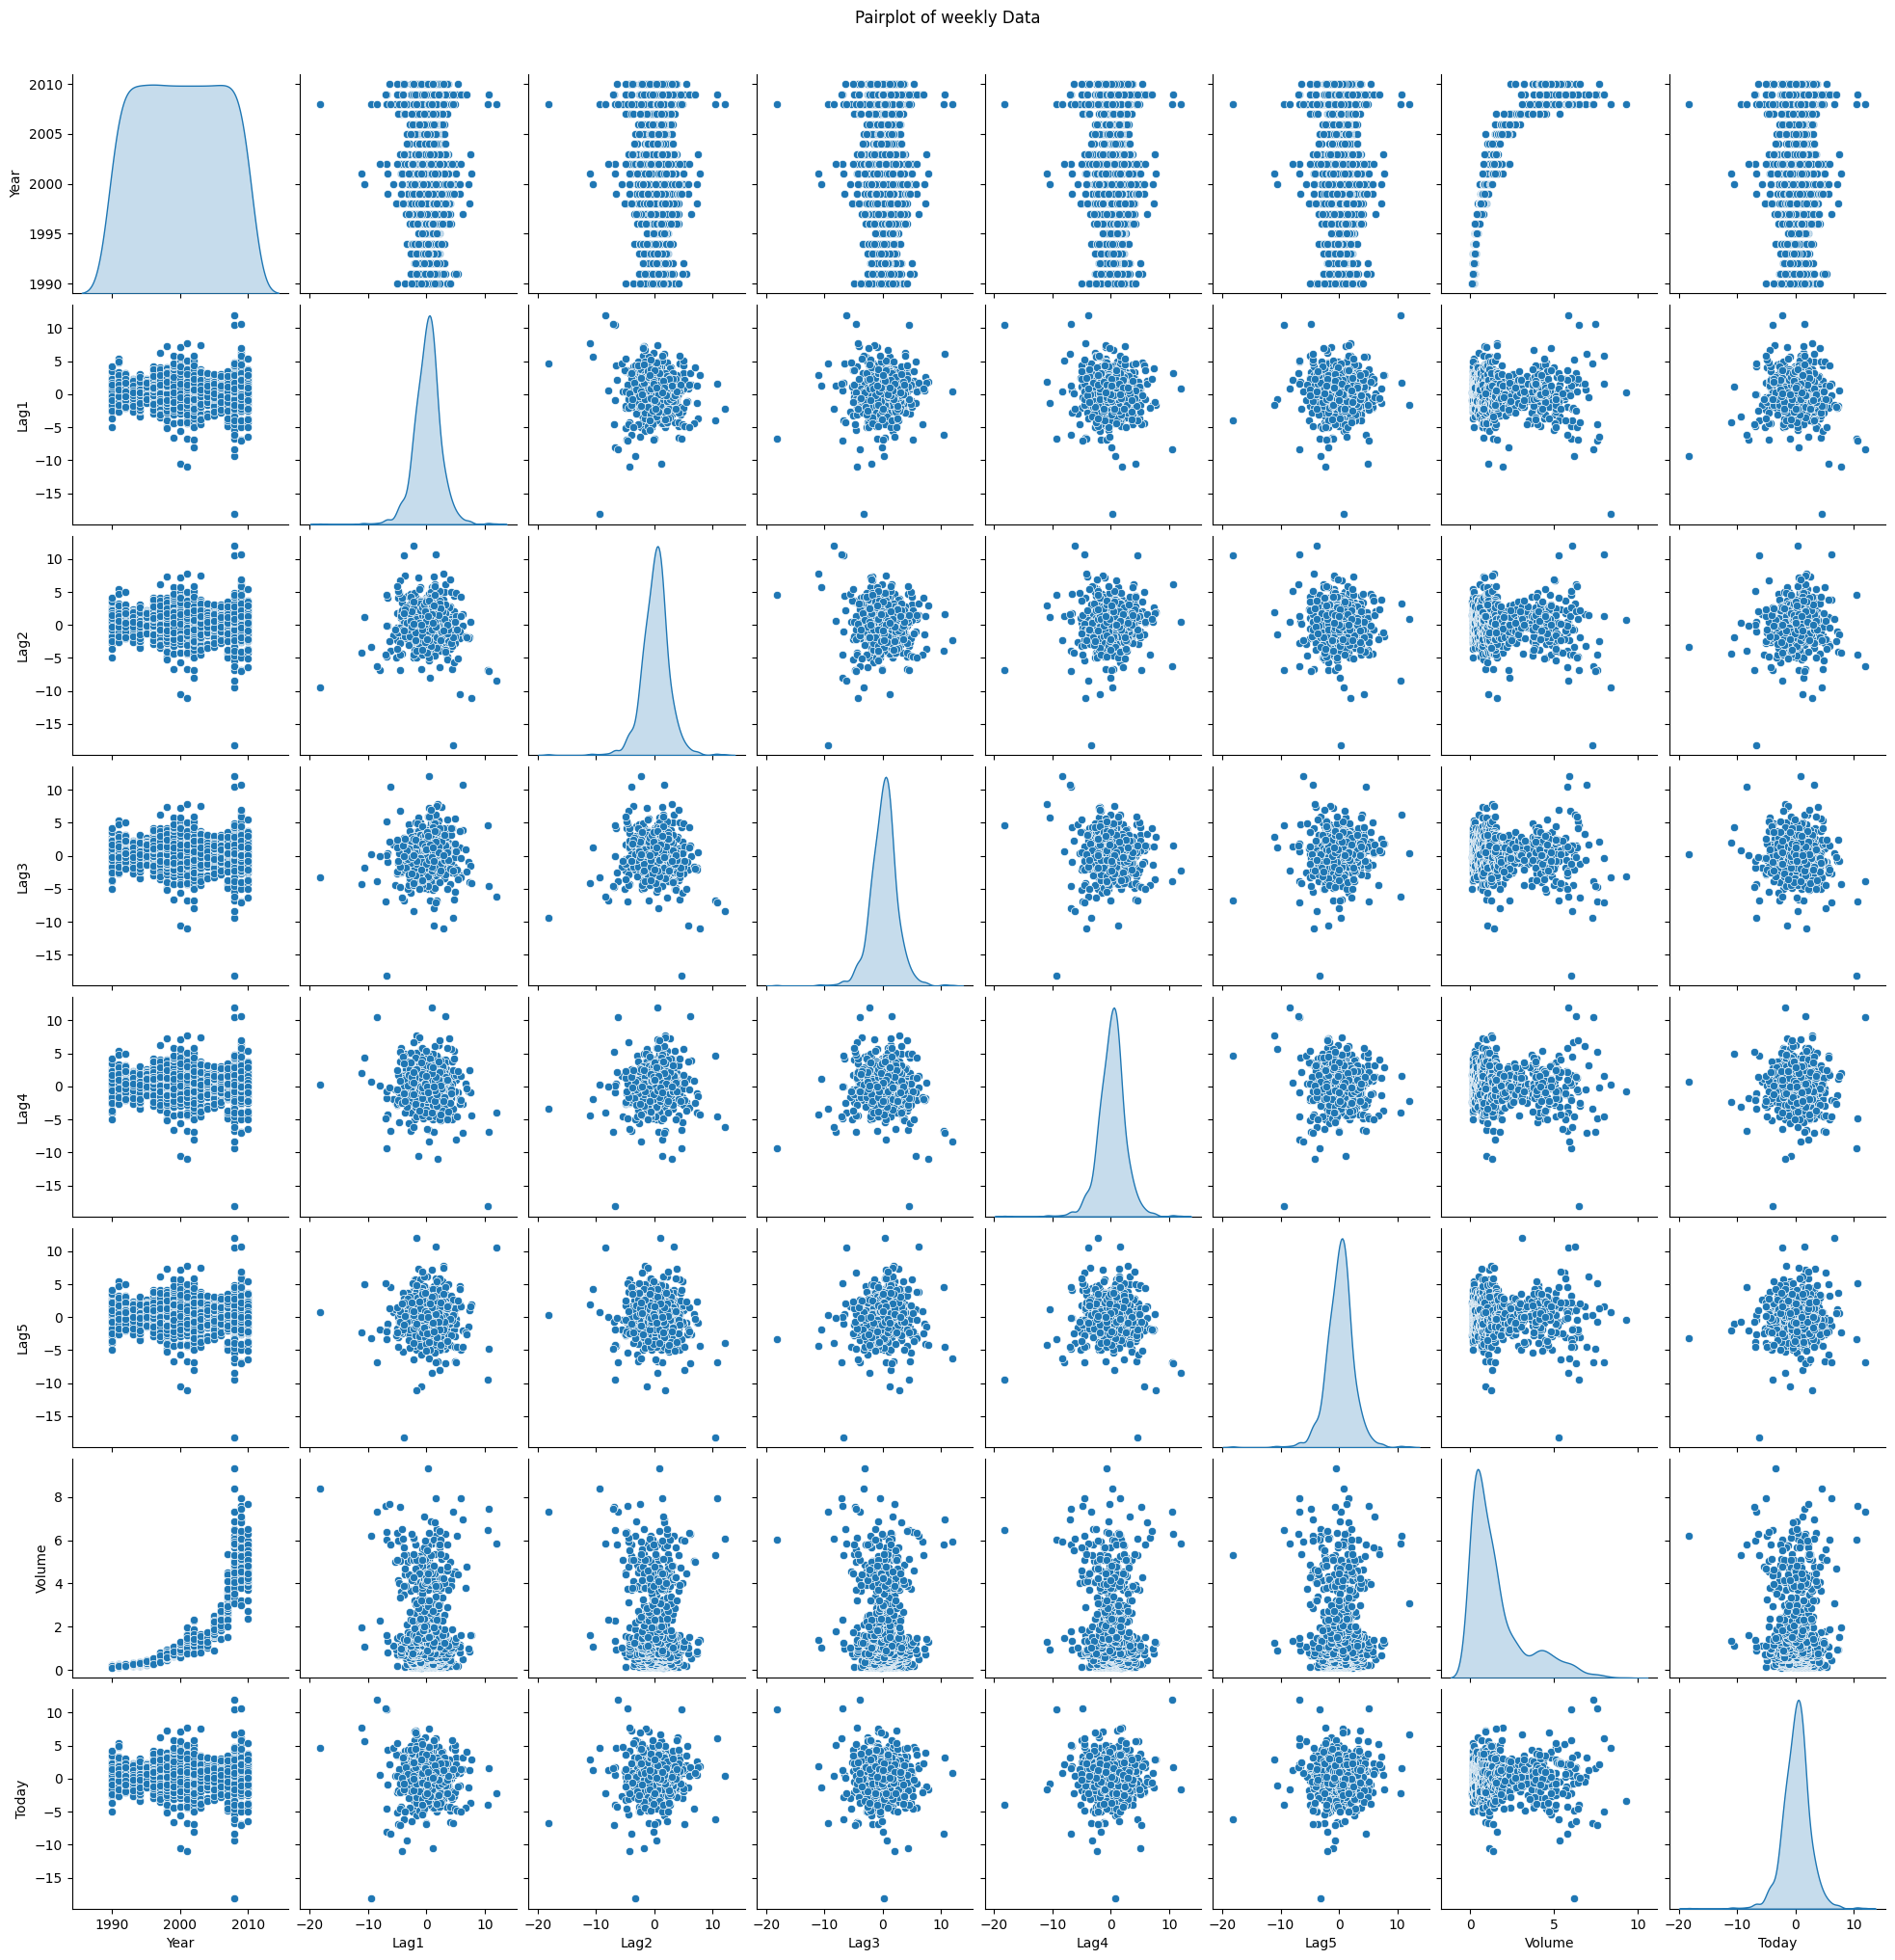

In [7]:
# Pairplot
sns.pairplot(weekly, diag_kind='kde')
plt.suptitle("Pairplot of weekly Data", y=1.02)
plt.show()

This dataset tracks weekly stock market data from 1990 to 2010. Each "lag" represent performance relative to n weeks prior, e.g., "lag1" represent performance relative to one week prior, "lag5" represents performance relative to 5 weeks prior. The most significant pattern to emerge for the data is the strong positive correlation between year and volume. However, this does not reveal information about returns or market performance, but simply the increase in market activity over time. No clear pattern has emerged for performance.

## Question 13b. 

Use the full data set to perform a logistic regression with  Direction as the response and the five lag variables plus Volume  as predictors. Use the summary function to print the results. Do  any of the predictors appear to be statistically significant? If so, which ones? 

In [8]:
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize

# Define predictors: drop non-predictive columns
predictors = weekly.columns.drop(['Today', 'Direction', 'Year'])

# Design matrix creation
design = MS(predictors)
X = design.fit_transform(weekly)

# Response variable: True if "Up"
y = weekly['Direction'] == 'Up'

# Fit logistic regression model
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()

# Display coefficients, p-values, z-scores
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


The results from this initial logistic regression is that intercept, Lag2, and Lag4 demonstrate statistical significance with a P-value < 0.5. P-value is our measure of randomness or chance. In other words, how likely is the outcome amongst noise. Our Y-intercept is added to the model by default by Python's stats model and it shows that if all predictors are zero, the response value still has a statistically significant positive trend. The statistical significance of Lag2 also suggests the if performance was positive 2 weeks ago, is is more likely to be positive today while Lag1 shows the opposite, albeit without statistical significance. Same can be said for the statistical significance of Lag4. Despite these results, the trends are counterintuitive for stock market trends and the model my be over-fitted or biased yielding a misleading result.

## Question 13c.

Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [9]:
from ISLP import confusion_table
import numpy as np


# Make predictions
probs = results.predict()

# Convert probabilities to class predictions
labels = np.where(probs > 0.5, 'Up', 'Down')
actual = weekly['Direction']

# Compute confusion matrix
print(confusion_table(labels, actual))

# Compute overall accuracy
accuracy = np.mean(labels == actual)
print(f"Overall accuracy: {accuracy:.4f}")


Truth      Down   Up
Predicted           
Down         54   48
Up          430  557
Overall accuracy: 0.5611


Total the model predicted correctly is 611 out of 1089 observations, leading to a 56% accuracy, only slightly better than chance. We predicted "up" 987 times, while the true instances of "up" were only 605, showing a high rate of false positives. 557 of the 605 "up" predictions, meaning 92% were correct. Meanwhile of 484 actual "down" instance, only 54 were predicted correctly. Thus recall is very high, but precision... sucks.

## Question 13d.

Now fit the logistic regression model using a training data period  from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions  for the held out data (that is, the data from 2009 and 2010).

In [10]:
# Train/test split by year
train_idx = weekly['Year'] <= 2008
test_idx = ~train_idx  # equivalent to Year > 2008

# Define model using only Lag2
design = MS(['Lag2'])
X = design.fit_transform(weekly)
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

# Binary response: True if Direction == 'Up'
y = weekly['Direction'] == 'Up'
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Fit logistic regression model on training data
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()

# Predict on test data
probs = results.predict(X_test)
labels = np.where(probs > 0.5, 'Up', 'Down')

# Actual test labels
actual = weekly['Direction'].loc[test_idx]

# Confusion matrix and accuracy
print(confusion_table(labels, actual))

accuracy = np.mean(labels == actual)
print(f"\nTest set accuracy: {accuracy:.4f}")

Truth      Down  Up
Predicted          
Down          9   5
Up           34  56

Test set accuracy: 0.6250


Accuracy increased with the newly fitted model. However, it still demonstrates signs of high recall and low precision as it correctly identifies many of the "Up" weeks but also frequently misclassifies "Down" weeks as "Up." This suggests the model remains biased toward predicting positive performance.

## Question 13e.

Repeat the (d) last question using Linear Discriminant Analysis (LDA)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Train/test split
train_idx = weekly['Year'] <= 2008
test_idx = ~train_idx

# Extract Lag2 only
X = weekly[['Lag2']]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

# Categorical response
y = weekly['Direction']
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Fit LDA
lda = LDA()
lda.fit(X_train, y_train)

# Predict on test set
lda_pred = lda.predict(X_test)

# Confusion matrix and accuracy
print(confusion_table(lda_pred, y_test))

accuracy = np.mean(lda_pred == y_test)
print(f"\nTest set accuracy: {accuracy:.4f}")

Truth      Down  Up
Predicted          
Down          9   5
Up           34  56

Test set accuracy: 0.6250


Linear Discriminant Analysis (LDA) produced virtually identical results to logistic regression on the same subset of data.

## Question 13f.

Repeat (13d) using Quadratic Discriminant Analysis (QDA).

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Load data
weekly = load_data('Weekly')

# Train/test split
train_idx = weekly['Year'] <= 2008
test_idx = ~train_idx

# Use only Lag2
X = weekly[['Lag2']]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

# Categorical response
y = weekly['Direction']
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Fit QDA model
qda = QDA()
qda.fit(X_train, y_train)

# Predict on test set
qda_pred = qda.predict(X_test)

# Evaluate
print(confusion_table(qda_pred, y_test))

accuracy = np.mean(qda_pred == y_test)
print(f"\nTest set accuracy: {accuracy:.4f}")


Truth      Down  Up
Predicted          
Down          0   0
Up           43  61

Test set accuracy: 0.5865


Quadratic Discriminant Analysis followed the bias toward predicting "Up". In fact, it predicted everything as "Up" and achieved a 58% accuracy. This suggests QDA did not determine a useful decision boundary or a separation between "Up" and "Down" based on Lag2 predictors.

## Question 13g.

Repeat question 13d using KNN with K = 1.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Load data
weekly = load_data('Weekly')

# Train/test split
train_idx = weekly['Year'] <= 2008
test_idx = ~train_idx

# Use only Lag2
X = weekly[['Lag2']]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

# Response
y = weekly['Direction']
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Fit KNN with K=1
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)

# Predict
knn1_pred = knn1.predict(X_test)

# Evaluate
print(confusion_table(knn1_pred, y_test))

accuracy = np.mean(knn1_pred == y_test)
print(f"\nTest set accuracy: {accuracy:.4f}")

Truth      Down  Up
Predicted          
Down         22  32
Up           21  29

Test set accuracy: 0.4904


KNN resulted in a noteworthy drop in performance at K=1. One nearest neighbor does not provide enough information for a broad pattern to emerge, and thus K=1 is overfitting.

## Question 13h.

Repeat question 13d using Naive Bayes.

In [14]:
from sklearn.naive_bayes import GaussianNB
# Load data
weekly = load_data('Weekly')

# Train/test split
train_idx = weekly['Year'] <= 2008
test_idx = ~train_idx

# Use only Lag2
X = weekly[['Lag2']]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

# Response
y = weekly['Direction']
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Fit Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict
nb_pred = nb.predict(X_test)

# Evaluate
print(confusion_table(nb_pred, y_test))

accuracy = np.mean(nb_pred == y_test)
print(f"\nTest set accuracy: {accuracy:.4f}")

Truth      Down  Up
Predicted          
Down          0   0
Up           43  61

Test set accuracy: 0.5865


Naive bayes predicted everything as the majority class just like QDA. Naive bayes models each class independently as a Gaussian normal distribution based on Lag2. However, Lag2 alone likely lacks enough independent information to be predictive.

## Question 13i.

Which of these methods appears to provide the best results on this data?

Although Naive Bayes and QDA had slightly higher accuracy, they achieved this by simply predicting "Up" all the time. Logistic regression or LDA are likely better choices overall, because they demonstrated some ability to distinguish between Up and Down weeks, rather than relying purely on the majority class.

## Question 13j.

Experiment with different combinations of predictors, including possible transformations and interactions, for each of the  methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held  out data. Note that you should also experiment with values for  K in the KNN classifier.

In [15]:
# Logistic Regression with Lag2 and Lag4

# Train/test split
train_idx = weekly['Year'] <= 2008
test_idx = ~train_idx

# Select predictors
X = weekly[['Lag2', 'Lag4']]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

# Response
y = weekly['Direction']
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Fit logistic regression
glm = sm.GLM((y_train == 'Up'), X_train, family=sm.families.Binomial())
results = glm.fit()

# Predict probabilities and classify
probs = results.predict(X_test)
preds = np.where(probs > 0.5, 'Up', 'Down')

# Confusion matrix and accuracy
print(confusion_table(preds, y_test))
print(f"\nTest set accuracy: {np.mean(preds == y_test):.4f}")


Truth      Down  Up
Predicted          
Down         21  27
Up           22  34

Test set accuracy: 0.5288


In [16]:
# LDA with Lag2 and Lag4

# Fit LDA
lda = LDA()
lda.fit(X_train, y_train)

# Predict
lda_preds = lda.predict(X_test)

# Evaluate
print(confusion_table(lda_preds, y_test))
print(f"\nTest set accuracy: {np.mean(lda_preds == y_test):.4f}")

Truth      Down  Up
Predicted          
Down          8   4
Up           35  57

Test set accuracy: 0.6250


In [17]:
# QDA with Lag2 and Lag4

# Fit QDA
qda = QDA()
qda.fit(X_train, y_train)

# Predict
qda_preds = qda.predict(X_test)

# Evaluate
print(confusion_table(qda_preds, y_test))
print(f"\nTest set accuracy: {np.mean(qda_preds == y_test):.4f}")


Truth      Down  Up
Predicted          
Down          9  14
Up           34  47

Test set accuracy: 0.5385


In [18]:
# KNN with Lag2 and Lag4 (first K=3)

# Fit KNN with K=3
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)

# Predict
knn3_preds = knn3.predict(X_test)

# Evaluate
print(confusion_table(knn3_preds, y_test))
print(f"\nTest set accuracy (K=3): {np.mean(knn3_preds == y_test):.4f}")


Truth      Down  Up
Predicted          
Down         24  23
Up           19  38

Test set accuracy (K=3): 0.5962


In [19]:
# KNN with Lag2 and Lag4 (first K=5)

# Fit KNN with K=3
knn3 = KNeighborsClassifier(n_neighbors=5)
knn3.fit(X_train, y_train)

# Predict
knn3_preds = knn3.predict(X_test)

# Evaluate
print(confusion_table(knn3_preds, y_test))
print(f"\nTest set accuracy (K=3): {np.mean(knn3_preds == y_test):.4f}")

Truth      Down  Up
Predicted          
Down         14  25
Up           29  36

Test set accuracy (K=3): 0.4808


The models tested using Lag2 and Lag4, LDA provided the best results with an overall test accuracy of 62.5%. It balanced predicting both "Up" and "Down" weeks reasonably well. KNN with K=3 was a close second but still slightly behind in accuracy. Logistic regression, QDA, and KNN with K=5 performed noticeably worse.

## Question 14

In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

In [37]:
# load auto dataset
auto = load_data('Auto')

# View the first few results
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


## Question 14a.

Create a binary variable, mpg01, that contains a 1 if mpg contains  a value above its median, and a 0 if mpg contains a value below  its median. You can compute the median using the median()  method of the data frame. Note you may find it helpful to add  a column mpg01 to the data frame by assignment. Assuming you  have stored the data frame as Auto, this can be done as follows: `Auto['mpg01'] = mpg01`

In [38]:
# Compute median of mpg
mpg_median = auto['mpg'].median()
print(f'mpg median: {mpg_median}')

# Create binary variable: 1 if mpg > median, else 0
auto['mpg01'] = (auto['mpg'] > mpg_median).astype(int)

# Check result
auto.head()

mpg median: 22.75


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
name,,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1,0
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1,0
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1,0
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1,0
ford torino,17.0,8,302.0,140,3449,10.5,70,1,0


## Question 14b.

Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other  features seem most likely to be useful in predicting mpg01? Scatter plots and box plots may be useful tools to answer this question. Describe your findings. 

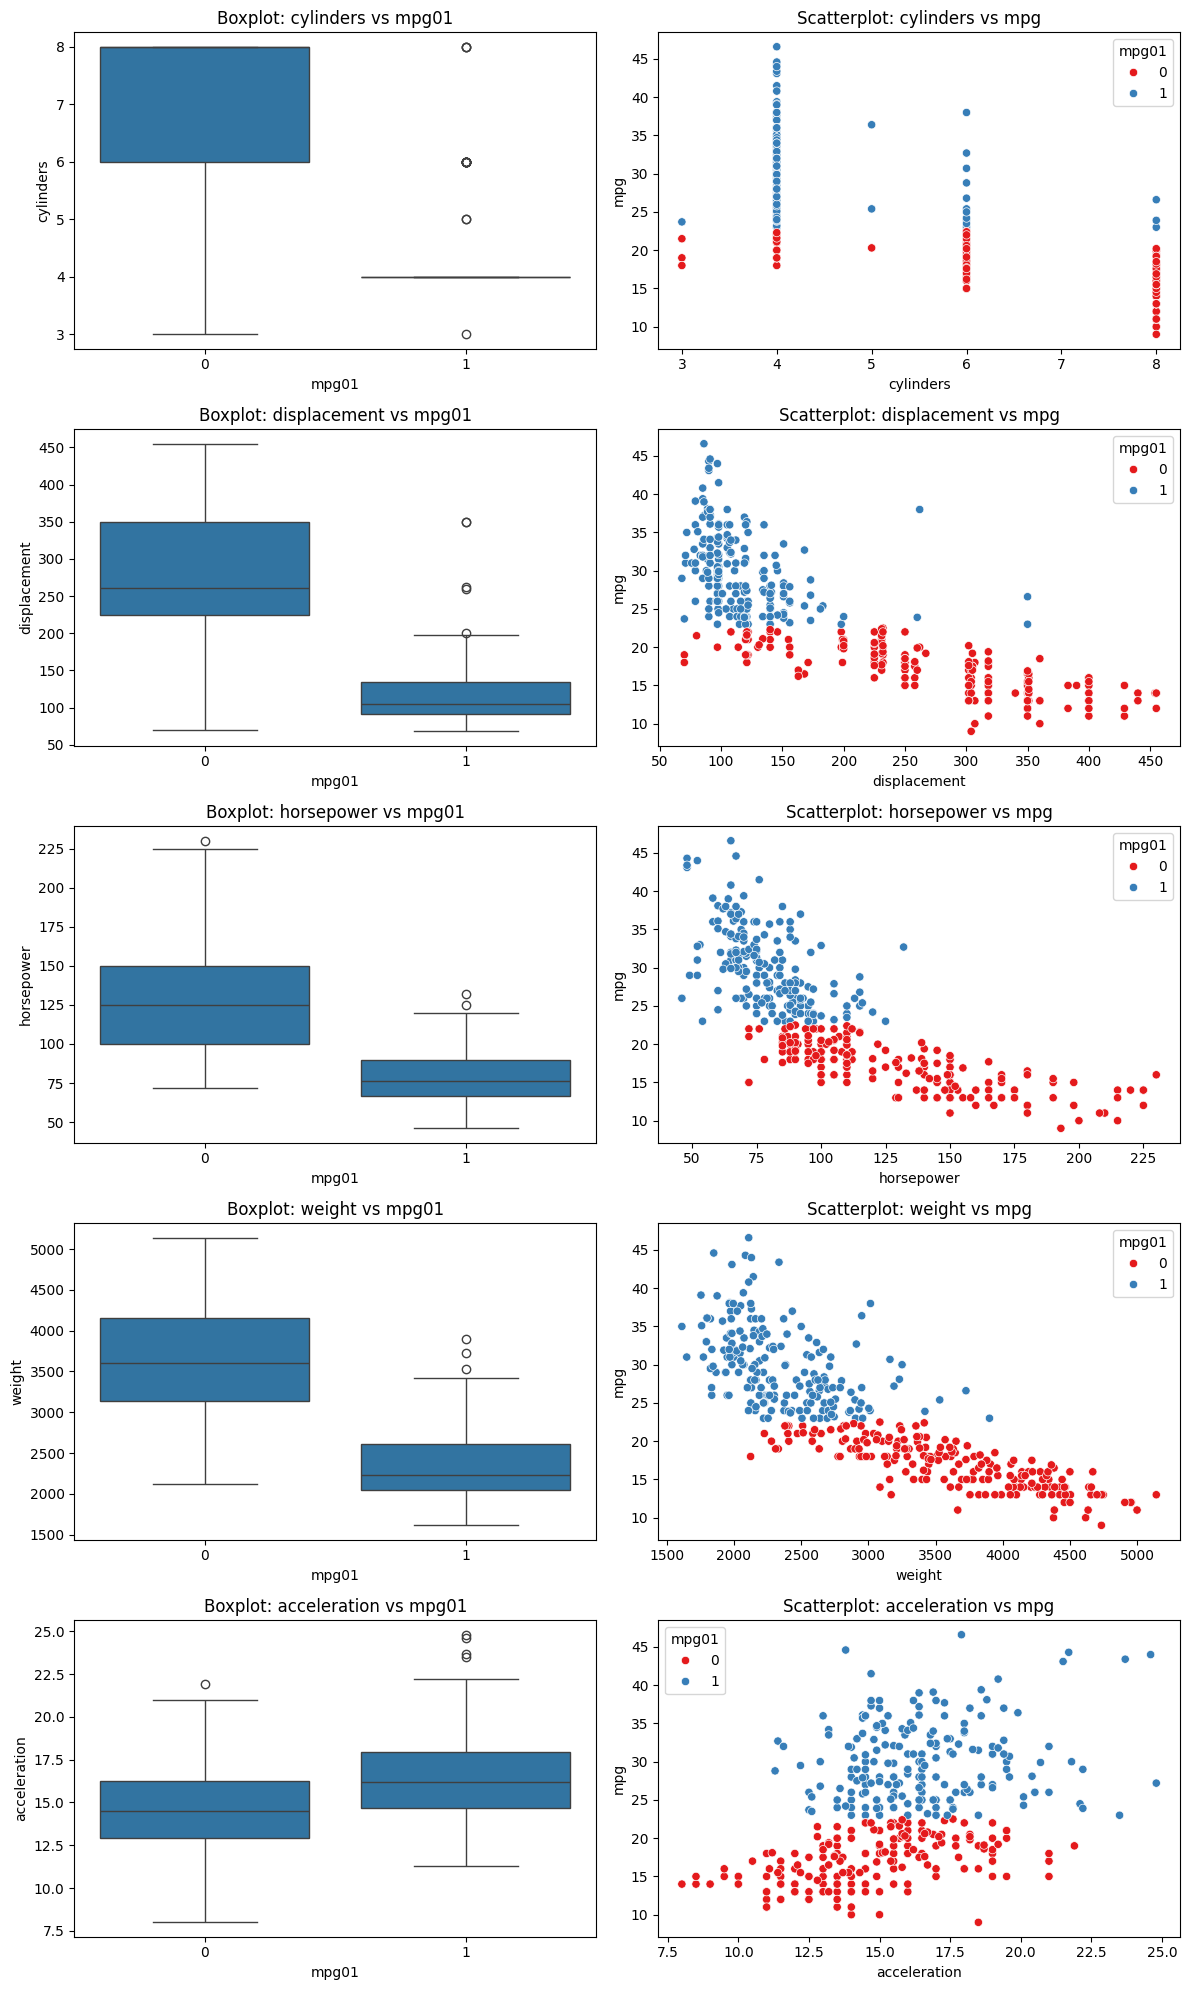

In [24]:
# Features to explore
features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']

# Setup figure
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 4 * len(features)))
fig.tight_layout(pad=4.0)

for i, feature in enumerate(features):
    # Boxplot
    sns.boxplot(x='mpg01', y=feature, data=auto, ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot: {feature} vs mpg01')
    axes[i, 0].set_xlabel('mpg01')
    axes[i, 0].set_ylabel(feature)

    # Scatterplot
    sns.scatterplot(x=feature, y='mpg', hue='mpg01', palette='Set1', data=auto, ax=axes[i, 1])
    axes[i, 1].set_title(f'Scatterplot: {feature} vs mpg')
    axes[i, 1].set_ylabel('mpg')

plt.tight_layout()
plt.show()

Cylinders: Vehicles with more cylinders tend to have lower fuel efficiency. 4-cylinder cars are mostly above the median MPG, while 8-cylinder cars are overwhelmingly below it. 6-cylinder vehicles appear more evenly split and less predictable.

Displacement: There is a strong negative relationship with fuel economy. Vehicles with displacement above 175 are almost exclusively below the median MPG.

Horsepower: Higher horsepower is associated with lower MPG. No vehicle in the dataset with over ~130 HP has high fuel efficiency.

Weight: Strong inverse correlation with MPG — heavier cars consistently show lower fuel economy.

Acceleration: No clear trend is observed. Acceleration appears to have limited predictive value for mpg01.

Overall, cylinders, displacement, horsepower, and weight appear to be strong predictors of whether a vehicle achieves above-median fuel economy, while acceleration is not useful on its own.

## Question 14c.

Split the data into a training set and a test set.

In [40]:
from sklearn.model_selection import train_test_split

# fix index
auto = auto.reset_index()

# Drop non-predictive or redundant columns
auto.drop(columns=['mpg', 'name'])

# Define predictors and response
X = auto.drop(columns='mpg01')
y = auto['mpg01']

# Split the data: 70% train, 30% test (you can adjust as needed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

# Confirm sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 274
Test set size: 118


## Question 14d.

Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
import numpy as np

# Select most predictive features
X_train_lda = X_train[['cylinders', 'displacement', 'horsepower', 'weight']]
X_test_lda = X_test[['cylinders', 'displacement', 'horsepower', 'weight']]

# Fit LDA model
lda = LDA()
lda.fit(X_train_lda, y_train)

# Predict on test data
lda_pred = lda.predict(X_test_lda)

# Confusion matrix and accuracy
cm = confusion_matrix(y_test, lda_pred)
accuracy = np.mean(lda_pred == y_test)
test_error = 1 - accuracy

print("Confusion matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Test error rate: {test_error:.4f}")

Confusion matrix:
[[58  7]
 [ 3 50]]

Accuracy: 0.9153
Test error rate: 0.0847


## Question 14e.

Perform QDA on the training data in order to predict `mpg01` using the variables that seemed most associated with `mpg01` in
(b). What is the test error of the model obtained?

In [44]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix
import numpy as np

# Use the same feature set as before
X_train_qda = X_train[['cylinders', 'displacement', 'horsepower', 'weight']]
X_test_qda = X_test[['cylinders', 'displacement', 'horsepower', 'weight']]

# Fit QDA model
qda = QDA()
qda.fit(X_train_qda, y_train)

# Predict on test data
qda_pred = qda.predict(X_test_qda)

# Confusion matrix and test error
cm = confusion_matrix(y_test, qda_pred)
accuracy = np.mean(qda_pred == y_test)
test_error = 1 - accuracy

print("Confusion matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Test error rate: {test_error:.4f}")

Confusion matrix:
[[61  4]
 [ 5 48]]

Accuracy: 0.9237
Test error rate: 0.0763


## Question 14f.

Perform logistic regression on the training data in order to predict `mpg01` using the variables that seemed most associated with `mpg01` in (b). What is the test error of the model obtained?

In [45]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import numpy as np

# Select predictor variables
X_train_log = X_train[['cylinders', 'displacement', 'horsepower', 'weight']]
X_test_log = X_test[['cylinders', 'displacement', 'horsepower', 'weight']]

# Add intercept term for statsmodels
X_train_log = sm.add_constant(X_train_log)
X_test_log = sm.add_constant(X_test_log)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train_log).fit()

# Predict probabilities and convert to 0/1
probs = logit_model.predict(X_test_log)
preds = np.where(probs > 0.5, 1, 0)

# Evaluate
cm = confusion_matrix(y_test, preds)
accuracy = np.mean(preds == y_test)
test_error = 1 - accuracy

print(logit_model.summary())
print("\nConfusion matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Test error rate: {test_error:.4f}")

Optimization terminated successfully.
         Current function value: 0.296161
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  mpg01   No. Observations:                  274
Model:                          Logit   Df Residuals:                      269
Method:                           MLE   Df Model:                            4
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                  0.5721
Time:                        20:22:18   Log-Likelihood:                -81.148
converged:                       True   LL-Null:                       -189.66
Covariance Type:            nonrobust   LLR p-value:                 8.194e-46
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.7488      1.800      5.415      0.000       6.220      13.277
cylinders        0.0728

## Question 14g.

Next, Perform naive Bayes on the training data in order to predict `mpg01` using the variables that seemed most associated with `mpg01` in (b). What is the test error of the model obtained?

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import numpy as np

# Select predictors
X_train_nb = X_train[['cylinders', 'displacement', 'horsepower', 'weight']]
X_test_nb = X_test[['cylinders', 'displacement', 'horsepower', 'weight']]

# Fit Naive Bayes model
nb = GaussianNB()
nb.fit(X_train_nb, y_train)

# Predict on test set
nb_preds = nb.predict(X_test_nb)

# Evaluate
cm = confusion_matrix(y_test, nb_preds)
accuracy = np.mean(nb_preds == y_test)
test_error = 1 - accuracy

print("Confusion matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Test error rate: {test_error:.4f}")

Confusion matrix:
[[60  5]
 [ 5 48]]

Accuracy: 0.9153
Test error rate: 0.0847


## Question 14h.

Perform KNN on the training data, with several values of K, in order to predict `mpg01`. Use only the variables that seemed most associated with `mpg01` in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Select predictors
X_train_knn = X_train[['cylinders', 'displacement', 'horsepower', 'weight']]
X_test_knn = X_test[['cylinders', 'displacement', 'horsepower', 'weight']]

# Try several values of K
k_values = [1, 3, 5, 7, 10]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train)
    preds = knn.predict(X_test_knn)
    accuracy = np.mean(preds == y_test)
    test_error = 1 - accuracy
    results.append((k, accuracy, test_error))

#  display structured results
import pandas as pd
pd.set_option('display.precision', 4)
results_df = pd.DataFrame(results, columns=['K', 'Accuracy', 'Test Error'])
print("\nSummary of KNN test errors:")
print(results_df)


Summary of KNN test errors:
    K  Accuracy  Test Error
0   1    0.8814      0.1186
1   3    0.8898      0.1102
2   5    0.8644      0.1356
3   7    0.8983      0.1017
4  10    0.9068      0.0932


## Question 16.

Using the Boston data set, ft classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, naive Bayes, and KNN models using various subsets of the predictors. Describe your findings.

In [52]:
from ISLP import load_data
import pandas as pd

# Load the data
boston = load_data('Boston')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.0063,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.0273,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.0273,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.0324,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.0691,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [53]:
# Create binary target: 1 if crime > median, else 0
boston['crim01'] = (boston['crim'] > boston['crim'].median()).astype(int)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim01
0,0.0063,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.0273,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.0273,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,0
3,0.0324,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,0
4,0.0691,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,0


In [ ]:
from sklearn.model_selection import train_test_split

# drop response and response
X = boston.drop(columns=['crim', 'crim01']) # predictors
y = boston['crim01'] # response

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# sanity
splitsets = [X_train, X_test, y_train, y_test]
for idx, split in enumerate(splitsets):
    print(f"{idx} size: {split.shape[0]}")

0 size: 354
1 size: 152
2 size: 354
3 size: 152


In [65]:
# logistic regression

import statsmodels.api as sm

X_train_log = sm.add_constant(X_train)
X_test_log = sm.add_constant(X_test)

logit_model = sm.Logit(y_train, X_train_log).fit()
probs = logit_model.predict(X_test_log)
log_preds = (probs > 0.5).astype(int)

log_accuracy = (log_preds == y_test).mean()
print(f"Logistic Regression Test Accuracy: {log_accuracy:.4f}")

Optimization terminated successfully.
         Current function value: 0.211675
         Iterations 11
Logistic Regression Test Accuracy: 0.9211


In [66]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda.fit(X_train, y_train)
lda_preds = lda.predict(X_test)

lda_accuracy = (lda_preds == y_test).mean()
print(f"LDA Test Accuracy: {lda_accuracy:.4f}")

LDA Test Accuracy: 0.8553


In [67]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)

nb_accuracy = (nb_preds == y_test).mean()
print(f"Naive Bayes Test Accuracy: {nb_accuracy:.4f}")

Naive Bayes Test Accuracy: 0.7632


In [68]:
from sklearn.neighbors import KNeighborsClassifier

for k in [1, 3, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    knn_accuracy = (knn_preds == y_test).mean()
    print(f"KNN (k={k}) Test Accuracy: {knn_accuracy:.4f}")

KNN (k=1) Test Accuracy: 0.9276
KNN (k=3) Test Accuracy: 0.9276
KNN (k=5) Test Accuracy: 0.9145
KNN (k=10) Test Accuracy: 0.8816


KNN (k=1 and 3) gave the best performance at 92.8% accuracy — likely benefiting from sharp local distinctions in feature space.

Logistic regression also performed very well (92.1%) and is more interpretable.

LDA performed decently, consistent with its assumptions of equal variance across classes.

Naïve Bayes had the lowest performance (76.3%), suggesting its strong assumption of independent features hurt performance.